# RNN Memory Model

In this workbook, we instantiate, train, and test a series of recurrent neural network (RNN) models of memory. The biological constraints imposed in the models are designed to simulate an abstract memory network, with parameters set to mimic pathological states of excitatory/inhibitory imbalance (e.g., ADHD). The implementation is structured around the `PsychRNN` toolbox [(Ehrlich et al. 2020, *eNeuro*)](https://www.eneuro.org/content/8/1/ENEURO.0427-20.2020).  


> **Justin Campbell, Hannah Khelfa, Anna Jacobsen**    
> BME 6005: Computational Neuroscience  
> Version:   03/15/2023

## 1. Import Libraries
Install `PsychRNN` toolbox and import helper libraries. A list of libraries available within the Google Collab doc are displayed.

In [1]:
%%capture
!pip install psychrnn

In [2]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

from psychrnn.tasks.delayed_discrim import DelayedDiscrimination
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.simulation import BasicSimulator

In [3]:
# Display package versions
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       4.3.1
astunparse                    1.6.3
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.9.3
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
bs4                           0.0.1
CacheControl                  0.12.11
cachetools                    5.3.0
catalogue                     2.0.8
certifi                       2022.12.7
c

## 2. Initialize Task & Models
1. Define parameters of a *Delayed Discrimination* task
  - Two stimuli are shown sequentially, separated by a delay. The goal of the task is to determine/remember which of the two stimuli are of greater intensity (here, intensity is an abstract value; may represent, for example, two sounds of different frequencies, or two visual cues of different luminance)  
2. Instantiate two basic RNN models:
  - Normal E/I balance (E/I 3:1)
  - Hyperexcitable E/I imbalance (E/I 9:1)
3. Plot model weights to visualize E/I

In [4]:
# Task params
dt = 10                 # The simulation timestep.
tau = 100               # The intrinsic time constant of neural state decay.
T = 2000                # The trial length.
N_batch = 100           # The number of trials per training update.
stim_duration_1 = 250   # The duration for stimulus 1
stim_duration_2 = 250   # The duration for stimulus 2
delay_duration = 500    # The duration for the delay between stimuli
decision_duration = 500 # The duration over which the RNN may determine output

# Instantiate task
task = DelayedDiscrimination(dt = dt, 
                             tau = tau, 
                             T = T, 
                             N_batch = N_batch,
                             stim_duration_1 = stim_duration_1,
                             stim_duration_2 = stim_duration_2,
                             delay_duration = delay_duration,
                             decision_duration = decision_duration) 

In [5]:
# Training params
train_params = {}
train_params['save_weights_path'] =  None # Where to save the model after training. Default: None
train_params['training_iters'] = 50000 # number of iterations to train for Default: 50000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['optimizer'] = tf.compat.v1.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True

In [6]:
# Define models

# Basic structure
network_params = task.get_task_params()
network_params['N_rec'] = 50 # num nodes/neurons

# E/I 3:1 model (Normal)
EI_ratio = 3 
if 'E3_I1_model' not in locals():
  E3_I1_network_params = network_params.copy()
  E3_I1_network_params['name'] = 'Normal'
  E3_I1_network_params['dale_ratio'] = EI_ratio / (EI_ratio + 1)
  E3_I1_model = Basic(E3_I1_network_params)
  E3_I1_weights = E3_I1_model.get_weights()

# E/I 9:1 model (Hyperexcitable)
EI_ratio = 9 
if 'E9_I1_model' not in locals():
  E9_I1_network_params = network_params.copy()
  E9_I1_network_params['name'] = 'Hyperexcitable'
  E9_I1_network_params['dale_ratio'] = EI_ratio / (EI_ratio + 1)
  E9_I1_model = Basic(E9_I1_network_params)
  E9_I1_weights = E9_I1_model.get_weights()

In [7]:
def plot_weights(weights, title=""):
    cmap = plt.set_cmap('RdBu_r')
    img = plt.matshow(weights, norm = Normalize(vmin = -.5, vmax = .5))
    plt.title(title)
    plt.colorbar()

<Figure size 432x288 with 0 Axes>

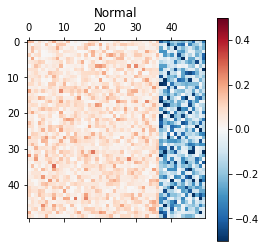

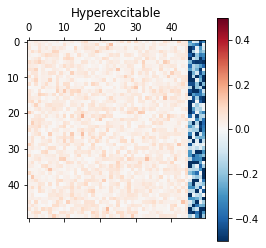

In [8]:
plot_weights(E3_I1_weights['W_rec'], title = E3_I1_network_params['name'])
plot_weights(E9_I1_weights['W_rec'], title = E9_I1_network_params['name'])

## 3. Simulate Models
1. Train models to perform task

In [9]:
# Train models
losses, initialTime, trainTime = E3_I1_model.train(task, train_params)
# losses, initialTime, trainTime = E9_I1_model.train(task, train_params)

Iter 1000, Minibatch Loss= 0.044540
Iter 2000, Minibatch Loss= 0.041300
Iter 3000, Minibatch Loss= 0.040565
Iter 4000, Minibatch Loss= 0.040102
Iter 5000, Minibatch Loss= 0.039737
Iter 6000, Minibatch Loss= 0.039549
Iter 7000, Minibatch Loss= 0.039000
Iter 8000, Minibatch Loss= 0.038953
Iter 9000, Minibatch Loss= 0.037895
Iter 10000, Minibatch Loss= 0.037737
Iter 11000, Minibatch Loss= 0.035955
Iter 12000, Minibatch Loss= 0.034181
Iter 13000, Minibatch Loss= 0.031944
Iter 14000, Minibatch Loss= 0.029039
Iter 15000, Minibatch Loss= 0.027798
Iter 16000, Minibatch Loss= 0.019320
Iter 17000, Minibatch Loss= 0.004312
Iter 18000, Minibatch Loss= 0.002834
Iter 19000, Minibatch Loss= 0.002249
Iter 20000, Minibatch Loss= 0.001916
Iter 21000, Minibatch Loss= 0.001556
Iter 22000, Minibatch Loss= 0.001220
Iter 23000, Minibatch Loss= 0.001165
Iter 24000, Minibatch Loss= 0.001058
Iter 25000, Minibatch Loss= 0.000955
Iter 26000, Minibatch Loss= 0.000835
Iter 27000, Minibatch Loss= 0.000830
Iter 28000

## 4. Model Characterization

Text(0.5, 1.0, 'Loss During Training')

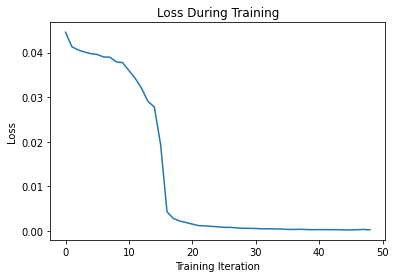

In [10]:
# Plot training
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

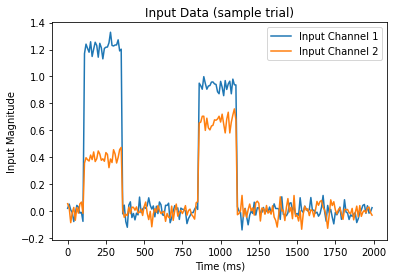

In [11]:
# Show sample trial
x, y, m, _ = task.get_trial_batch()
plt.plot(range(0, len(x[0,:,:]) * dt, dt), x[0,:,:])
plt.ylabel("Input Magnitude")
plt.xlabel("Time (ms)")
plt.title("Input Data (sample trial)")
plt.legend(["Input Channel 1", "Input Channel 2"])
plt.show()

In [12]:
simulator = BasicSimulator(rnn_model = E3_I1_model)
outputs, states = simulator.run_trials(x)

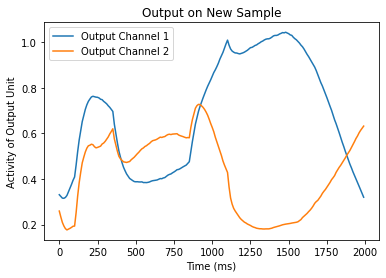

In [13]:
plt.plot(range(0, len(outputs[0,:,:]) * dt, dt), outputs[0,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")
plt.legend(["Output Channel 1", "Output Channel 2"])
plt.show()

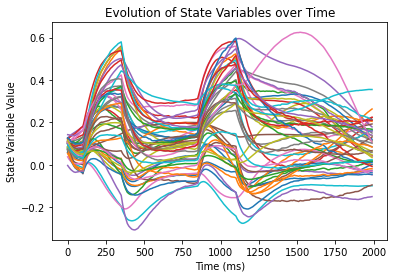

In [14]:
plt.plot(range(0, len(states[0,:,:]) * dt, dt), states[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")
plt.show()

In [14]:
task.accuracy_function